# 改進 SHINE 模型，將Sentiment、Social Network Autoencoder 替換成 lightCGN, Profile 則維持 AE

In [1]:
import os
import timeit
import numpy as np
from prepare_data_new import Data
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Embedding, concatenate, Dot, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as bk
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ["path"] += os.pathsep + 'c:/program files (x86)/graphviz2.38/bin'
# saveDir = "C:/Users/user/Google 雲端硬碟/NCKU_NETAI/SHINE/DGE/model"

# 一、讀取資料，包含:
1. Sentiment Graph
2. Social Relation Graph
3. Profile Bipartite Graph

In [3]:
train_ratio = 1
data = Data('data/sentiment.csv',
            'data/social_relation.csv',
            'data/celebrity_profile.csv',
            'data/ordinary_user_profile.csv',
            train_ratio,
            random_state=20) # random_state 設 0 為SHINE原始碼所用之切割，效果會最好。
holders_id_train, targets_id_train, holders_id_test, targets_id_test, holders_sen_adj_train, targets_sen_adj_train, y_train, holders_sen_adj_test, targets_sen_adj_test, y_test, adj_s = data.get_sentiment_data()
holders_soc_adj_train, targets_soc_adj_train, holders_soc_adj_test, targets_soc_adj_test, adj_r = data.get_relation_data()
holders_pro_train, targets_pro_train, holders_pro_test, targets_pro_test, adj_o, adj_c = data.get_profile_data()

# 整數轉換成浮點數
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
holders_pro_train = holders_pro_train.astype(np.float32)
targets_pro_train = targets_pro_train.astype(np.float32)
holders_pro_test = holders_pro_test.astype(np.float32)
targets_pro_test = targets_pro_test.astype(np.float32)

num_user = adj_s.shape[0]
num_data = len(holders_id_train)
input_dim_adj_vec = holders_sen_adj_train.shape[1]
input_dim_op = holders_pro_train.shape[1]
input_dim_cp = targets_pro_train.shape[1]

print("num of user:", num_user)
print("num of data:", num_data)
print("dim of ordinary", input_dim_op)
print("dim of celebrity", input_dim_cp)

num of user: 12814
num of data: 52336
dim of ordinary 37
dim of celebrity 108


---

# 二、建構模型

## 定義超參數

In [4]:
epoch_size = 5
batch_size = 1000
l2_weight = 0
lambda_pro = 1
lambda_output = 10
sen_act = 'relu'
soc_act = 'sigmoid'
pro_act = 'sigmoid'
optimizer = Adam(learning_rate=0.001)
EMBEDDING_DIM = 64
n_layers = 1

## 定義 GCN Layer

In [5]:
def create_lightgcn_embed(adj, name, n_layers=3):
    initializer = tf.initializers.GlorotUniform()
    c_adj = bk.constant(adj)
    ego_embeddings = tf.Variable(initializer([num_user, EMBEDDING_DIM]), name=name)
    all_embeddings = [ego_embeddings]

    for k in range(0, n_layers):
        #將adj矩陣和ego相乘
        side_embeddings = bk.dot(c_adj, ego_embeddings)
        ego_embeddings = side_embeddings
        all_embeddings += [ego_embeddings]

    # 將每一層 GCN Layer 的結果全部 Concatenate 起來，可以保留不同視野下的資訊並減少 Over-Smooth問題
    all_embeddings = tf.stack(all_embeddings, 1)
    all_embeddings = tf.reduce_mean(all_embeddings, axis=1, keepdims=False)

    return all_embeddings

### 定義幾個 Loss function

In [6]:
# put more weight on non-zero terms
alpha = 10
def reconstruction_loss(y_true, y_pred):
    sqr = bk.square(y_pred - y_true)
    weight = bk.abs(y_true) * (alpha - 1) + 1
    return bk.sum(sqr * weight, axis=-1)

def proximity_loss(y_true, y_pred):
    return bk.sum(-y_pred * y_true, axis=-1)

def proximity_loss_paper(y_true, y_pred):
      return  bk.sum(bk.square(y_true - y_pred))

### 定義模型結構

In [7]:
# placeholder definition
holder_input = Input(name='holder_index_input', shape=(1), dtype=tf.int32)
target_input = Input(name='target_index_input', shape=(1), dtype=tf.int32)

########## Sentiment and Social GCN ##########
# Use GCN layer to obtain the embedding table
sen_emb_table = Embedding(num_user,
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(create_lightgcn_embed(adj_s, name="sen", n_layers=n_layers)),
                          embeddings_regularizer=l2(l2_weight),
                          trainable=True,
                          input_shape=(None, ))

soc_emb_table = Embedding(num_user,
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(create_lightgcn_embed(adj_r, name="soc", n_layers=n_layers)),
                          embeddings_regularizer=l2(l2_weight),
                          trainable=True,
                          input_shape=(None, ))

# Lookup the embedding table to obtain the embeddings of holder and target in both graph
holder_sen_emb = sen_emb_table(holder_input)
target_sen_emb = sen_emb_table(target_input)
holder_soc_emb = soc_emb_table(holder_input)
target_soc_emb = soc_emb_table(target_input)

# dot product of two users
sen_proximity = Dot(axes=-1, normalize=True)([holder_sen_emb, target_sen_emb])
soc_proximity = Dot(axes=-1, normalize=True)([holder_soc_emb, target_soc_emb])


########## Profile graph autoencoder ##########
# o: ordinary people, c: celebrity
# Input layer
pro_o_input = Input(shape=(input_dim_op,))
pro_c_input = Input(shape=(input_dim_cp,))

# encoder
pro_o_encoder = Dense(EMBEDDING_DIM, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_c_encoder = Dense(EMBEDDING_DIM, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_o_emb = pro_o_encoder(pro_o_input)
pro_c_emb = pro_c_encoder(pro_c_input)

# decoder
pro_o_decoder = Dense(input_dim_op, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_c_decoder = Dense(input_dim_cp, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_recon_o = pro_o_decoder(pro_o_emb)
pro_recon_c = pro_c_decoder(pro_c_emb)

# dot product of two users
pro_proximity = Dot(axes=-1, normalize=True)([pro_o_emb, pro_c_emb])



########## Aggregation layer ##########
# 最終預測情感值
proximity = Add()([sen_proximity, soc_proximity, pro_proximity])


# 訓練用模型
model = Model(inputs=[holder_input, target_input, pro_o_input, pro_c_input],
              outputs=[proximity, pro_recon_o, pro_recon_c])

model.compile(optimizer=optimizer,
              loss=[proximity_loss, reconstruction_loss, reconstruction_loss],
              loss_weights=[lambda_output, lambda_pro, lambda_pro])

# 預測用模型
predict_model = Model(inputs=[holder_input, target_input, pro_o_input, pro_c_input], outputs=proximity)

### 訓練模型

In [8]:
start = timeit.default_timer()
h = model.fit(x=[holders_id_train, targets_id_train, holders_pro_train, targets_pro_train],
              y=[y_train, holders_pro_train, targets_pro_train],
              epochs=epoch_size,
              batch_size=batch_size,
#               validation_split=0.1),
              validation_data=([holders_id_test, targets_id_test, holders_pro_test, targets_pro_test],
                               [y_test, holders_pro_test, targets_pro_test]))
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/5


/home/q56084098/.local/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


53/53 [==============================] - 1s 11ms/step - loss: 31.4211 - add_loss: -1.1093 - dense_2_loss: 9.4379 - dense_3_loss: 33.0757 - val_loss: 31.5415 - val_add_loss: -0.0714 - val_dense_2_loss: 6.9230 - val_dense_3_loss: 25.3322
Epoch 2/5
53/53 [==============================] - 0s 6ms/step - loss: 14.5257 - add_loss: -1.5489 - dense_2_loss: 6.3099 - dense_3_loss: 23.7047 - val_loss: 27.3309 - val_add_loss: -0.1777 - val_dense_2_loss: 6.0451 - val_dense_3_loss: 23.0631
Epoch 3/5
53/53 [==============================] - 0s 6ms/step - loss: 8.7582 - add_loss: -1.9120 - dense_2_loss: 5.7707 - dense_3_loss: 22.1077 - val_loss: 24.7062 - val_add_loss: -0.2574 - val_dense_2_loss: 5.6368 - val_dense_3_loss: 21.6434
Epoch 4/5
53/53 [==============================] - 0s 6ms/step - loss: 4.4596 - add_loss: -2.1537 - dense_2_loss: 5.3832 - dense_3_loss: 20.6139 - val_loss: 22.3411 - val_add_loss: -0.2918 - val_dense_2_loss: 5.2340 - val_dense_3_loss: 20.0255
Epoch 5/5
53/53 [==============

In [9]:
h.history.keys()

dict_keys(['loss', 'add_loss', 'dense_2_loss', 'dense_3_loss', 'val_loss', 'val_add_loss', 'val_dense_2_loss', 'val_dense_3_loss'])

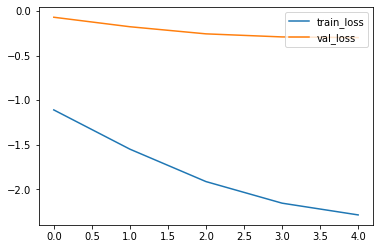

In [10]:
plt.plot(h.history['add_loss'], label='train_loss')
plt.plot(h.history['val_add_loss'], label='val_loss')
plt.legend(loc='upper right')

plt.show()

### 效果評估
使用 Metric:
- Accuracy
- Precision
- Recall
- F1-Score
- AUC

In [11]:
def result(X, Y, mode=''):
    # 模型預測值
    y_predict_raw = predict_model.predict(X).flatten()
    y_predict = y_predict_raw.copy()
    
    # 計算中位數當作二分的門檻值
    y_threshold = np.median(y_predict_raw)
    y_predict[y_predict_raw < y_threshold] = -1
    y_predict[y_predict_raw >= y_threshold] = 1
    
    # 用 Ground Truth 計算各種 Metrics
    accuracy = accuracy_score(Y, y_predict)
    f1 = f1_score(Y, y_predict, average='binary')
    AUC = roc_auc_score(Y, y_predict_raw)
    print(mode)
    print(accuracy)
    print(f1)
    print(AUC)
    print()

print("Acc, F1, AUC:")

result(X=[holders_id_train, targets_id_train, holders_pro_train, targets_pro_train], Y=y_train, mode='Train')
result(X=[holders_id_test, targets_id_test, holders_pro_test, targets_pro_test], Y=y_test, mode='Test')


Acc, F1, AUC:
Train
0.5908743503515744
0.7084819605173588
0.9408959817030929

Test
0.6763245033112583
0.6763245033112583
0.7392171670102188



In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
holder_index_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
target_index_input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 108)]        0                                            
_______________________________________________________________________________________